In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats

## Task 1

In [2]:
# 1. Load the data
file_path = 'Assignemnt1_EF_data.xlsx'
df = pd.read_excel(file_path)

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

df['US 3 month'] = df['US 3 month']/1200
df['UK 3 month'] = df['UK 3 month']/1200
df['US 10 Year'] = df['US 10 Year']/1200
df['UK 10 Year'] = df['UK 10 Year']/1200


# 2. Select US Data
us_data = df[['US 10 Year', 'US 3 month',
              'US Stock Market', 'USDperGBP']].copy()

# Calculate log returns for the Stock Market and Exchange Rate
us_data['US Stock Returns'] = np.log(
    us_data['US Stock Market'] / us_data['US Stock Market'].shift(1))
us_data['FX Returns'] = np.log(
    us_data['USDperGBP'] / us_data['USDperGBP'].shift(1))

# Drop first row due to NaNs from returns
us_data_clean = us_data.dropna()

us_data_clean.head()

,US 10 Year,US 3 month,US Stock Market,USDperGBP,US Stock Returns,FX Returns
Date,,,,,,
1956-02-29,0.002367,0.001917,13.492372,2.8088,0.037079,0.000855
1956-03-31,0.002467,0.001917,14.472296,2.8048,0.070112,-0.001425
1956-04-30,0.002650,0.002242,14.486981,2.8059,0.001014,0.000392
1956-05-31,0.002558,0.002142,13.577881,2.8025,-0.064808,-0.001212
1956-06-30,0.002500,0.002017,14.156344,2.7980,0.041721,-0.001607


In [3]:

# ---------------------------------------------------------
# Question 1: Summary Statistics
# ---------------------------------------------------------
summary_stats = us_data_clean.describe().T
summary_stats['Skewness'] = us_data_clean.skew()
summary_stats['Kurtosis'] = us_data_clean.kurtosis()  # Excess kurtosis
print("--- Summary Statistics ---")
print(summary_stats)

--- Summary Statistics ---
                  count         mean          std           min        25%  \
US 10 Year        840.0     0.004703     0.002406  4.583333e-04   0.003167   
US 3 month        840.0     0.003621     0.002578  8.333333e-07   0.001810   
US Stock Market   840.0  1802.838660  2949.160368  1.278138e+01  51.683236   
USDperGBP         840.0     1.898279     0.522206  1.079000e+00   1.510375   
US Stock Returns  840.0     0.008428     0.042486 -2.425156e-01  -0.015561   
FX Returns        840.0    -0.000855     0.025241 -1.397979e-01  -0.011841   

                         50%          75%           max  Skewness  Kurtosis  
US 10 Year          0.004125     0.006169      0.013200  0.874836  0.615155  
US 3 month          0.003625     0.004869      0.012933  0.760117  0.855781  
US Stock Market   402.439500  1999.452250  15441.150000  2.392191  5.674453  
USDperGBP           1.692900     2.387625      2.817500  0.625791 -0.989684  
US Stock Returns    0.012524     0.0

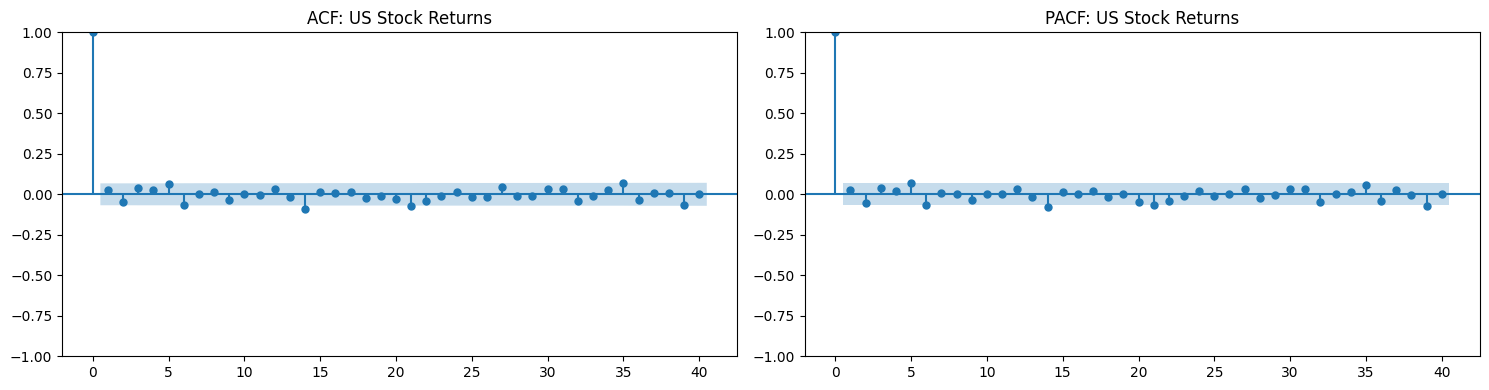

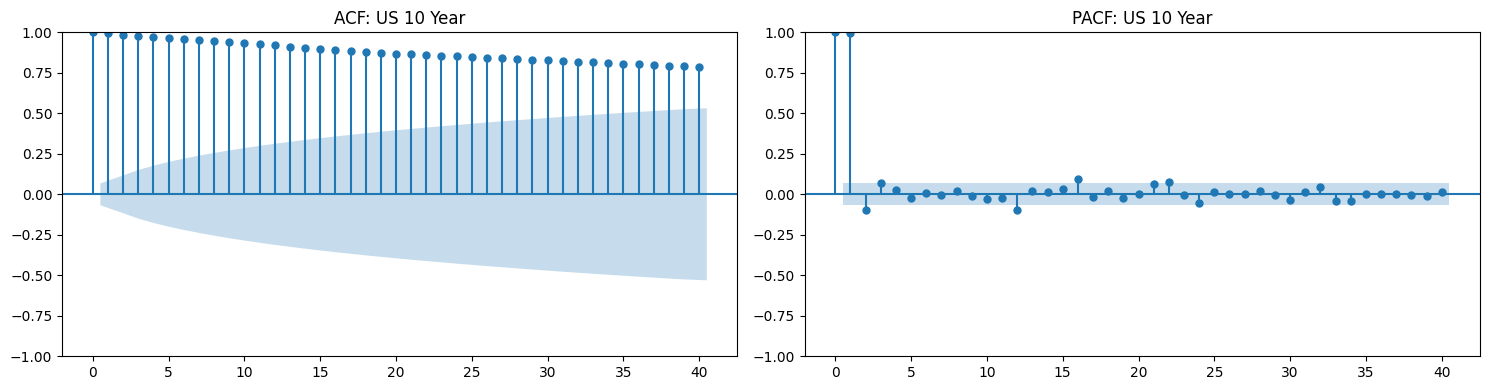

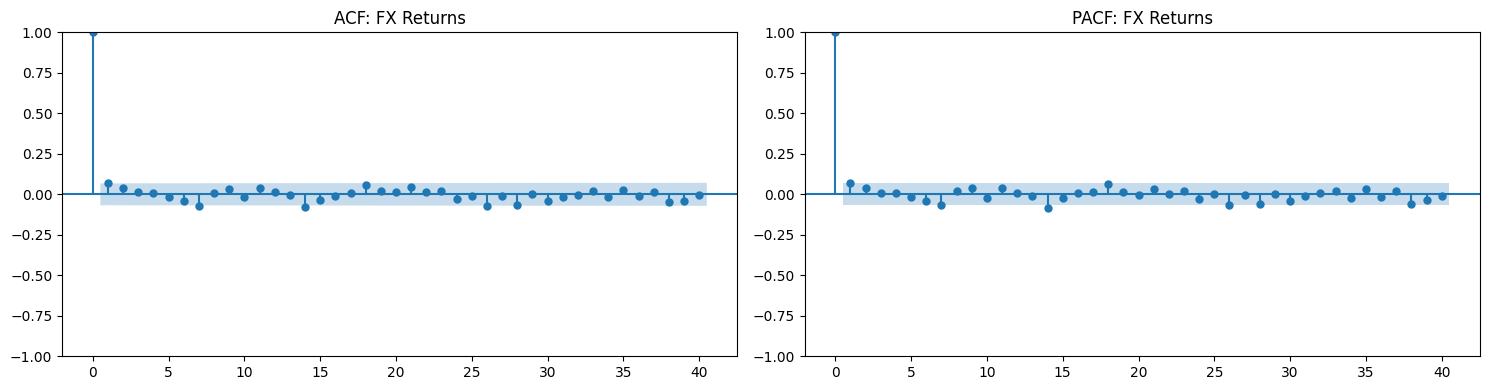

In [4]:

# ---------------------------------------------------------
# Question 2: ACF and PACF Plots
# ---------------------------------------------------------
variables_to_plot = ['US Stock Returns', 'US 10 Year', 'FX Returns']

for var in variables_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(us_data_clean[var], ax=axes[0], lags=40, title=f'ACF: {var}')
    plot_pacf(us_data_clean[var], ax=axes[1], lags=40, title=f'PACF: {var}')
    plt.tight_layout()
    plt.show()

## Task 2

# Task 3

In [5]:
equity_indices = df[['US 3 month', 'US Stock Market', 'UK Stock Market']]
equity_indices

,US 3 month,US Stock Market,UK Stock Market
Date,,,
1956-01-31,0.001933,13.001249,6.8667
1956-02-29,0.001917,13.492372,6.5458
1956-03-31,0.001917,14.472296,6.5519
1956-04-30,0.002242,14.486981,7.1767
1956-05-31,0.002142,13.577881,6.9279
...,...,...,...
2025-09-30,0.003350,14826.800000,11557.4600
2025-10-31,0.003242,15173.950000,11986.7100
2025-11-30,0.003233,15211.140000,12031.2695


In [6]:
riskless_rate = df['US 3 month']

In [7]:
from numpy.linalg import inv

df['Y'] = np.log(df['US Stock Market'] / df['US Stock Market'].shift(1))

# Prédicteur (X) : Term Spread (Taux Long - Taux Court)
# Note : On utilise le Spread décalé d'une période (t-1) pour prédire Y (t)
df['Spread'] = df['US 10 Year'] - df['US 3 month']
df['X'] = df['Spread'].shift(1)

# Nettoyage des données manquantes (le premier décalage crée un NA)
df_clean = df[['Y', 'X']].dropna()

# --- 2. Paramètres de la Fenêtre Glissante ---
window_size = 120  # 10 ans de données mensuelles
T = len(df_clean)

# Listes pour stocker les prévisions et les réalisations
preds_bench = []  # Modèle Benchmark (Moyenne historique)
preds_comp = []  # Modèle Concurrent (Régression Prédictive)
actuals = []     # Vraies valeurs réalisées

# --- 3. Boucle Rolling Window ---
print(f"Démarrage de la fenêtre glissante sur {T - window_size} périodes...")

for t in range(window_size, T):
    # A. Définition des échantillons d'entraînement (Train Set)
    # On utilise les données de [t - window] jusqu'à [t-1]
    train_Y = df_clean['Y'].iloc[t-window_size: t]
    train_X = df_clean['X'].iloc[t-window_size: t]

    # B. Valeurs actuelles pour la prévision (Test Set)
    # On veut prédire Y en 't'. Pour cela, on utilise X en 't'
    # (qui contient déjà la valeur du Spread en t-1 grâce au shift fait plus haut)
    y_target = df_clean['Y'].iloc[t]
    x_current = df_clean['X'].iloc[t]

    # C. Modèle 1 : Benchmark (Moyenne Historique)
    # Prévision = Moyenne des rendements passés dans la fenêtre
    pred_bench = train_Y.mean()
    preds_bench.append(pred_bench)

    # D. Modèle 2 : Concurrent (Predictive Regression)
    # Y_t = alpha + beta * X_{t-1}
    X_train_ols = sm.add_constant(train_X)
    model = sm.OLS(train_Y, X_train_ols).fit()

    # Prévision : alpha_hat + beta_hat * X_current
    # params[0] est la constante, params[1] est le coefficient de X
    pred_comp = model.params.iloc[0] + model.params.iloc[1] * x_current
    preds_comp.append(pred_comp)

    # Stockage de la réalisation
    actuals.append(y_target)

# --- 4. Évaluation Hors-Échantillon (OOS) ---
# Conversion en numpy arrays pour les calculs
preds_bench = np.array(preds_bench)
preds_comp = np.array(preds_comp)
actuals = np.array(actuals)

# Calcul des erreurs de prévision
e_bench = actuals - preds_bench
e_comp = actuals - preds_comp

# MSE (Mean Squared Error)
mse_bench = np.mean(e_bench**2)
mse_comp = np.mean(e_comp**2)

# A. OOS R-squared
# Formule : 1 - (MSE_model / MSE_benchmark)
oos_r2 = 1 - (mse_comp / mse_bench)

# B. Test de Clark and West (CW)
# Ajustement MSPE pour modèles emboîtés
# f_t = (e_bench)^2 - (e_comp)^2 + (pred_bench - pred_comp)^2
f_t = (e_bench**2) - (e_comp**2) + (preds_bench - preds_comp)**2

# Le test CW est un test t sur la moyenne de f_t > 0
# On calcule la t-statistique standard
cw_mean = np.mean(f_t)
cw_std = np.std(f_t, ddof=1)
cw_n = len(f_t)
cw_stat = cw_mean / (cw_std / np.sqrt(cw_n))

# p-value (test unilatéral à droite)
cw_pvalue = 1 - stats.norm.cdf(cw_stat)

# --- 5. Affichage des Résultats ---
print("-" * 30)
print("RÉSULTATS EXERCICE 2")
print("-" * 30)
print(f"Nombre de prévisions OOS : {len(actuals)}")
print(f"OOS R-squared            : {oos_r2:.4%}")
print(f"Statistique Clark & West : {cw_stat:.4f}")
print(f"P-value Clark & West     : {cw_pvalue:.4f}")
print("-" * 30)

# Interprétation rapide pour vous
if cw_pvalue < 0.05:
    print("Conclusion : Le modèle prédictif bat significativement le benchmark (à 5%).")
else:
    print("Conclusion : Pas de surperformance significative du modèle prédictif.")

Démarrage de la fenêtre glissante sur 720 périodes...
------------------------------
RÉSULTATS EXERCICE 2
------------------------------
Nombre de prévisions OOS : 720
OOS R-squared            : -0.4740%
Statistique Clark & West : 1.5688
P-value Clark & West     : 0.0583
------------------------------
Conclusion : Pas de surperformance significative du modèle prédictif.


In [8]:
from numpy.linalg import inv
df['UK Stock USD'] = df['UK Stock Market'] * df['USDperGBP']

# Calcul des Rendements (Log Returns)
df['r_us'] = np.log(df['US Stock Market'] / df['US Stock Market'].shift(1))
df['r_uk'] = np.log(df['UK Stock USD'] / df['UK Stock USD'].shift(1))

df['rf'] = df['US 3 month']
df['rf_lag'] = df['rf'].shift(1)

df['ex_us'] = df['r_us'] - df['rf_lag']
df['ex_uk'] = df['r_uk'] - df['rf_lag']

df['spread_us'] = df['US 10 Year'] - df['US 3 month']
df['spread_uk'] = df['UK 10 Year'] - df['UK 3 month']

df['pred_us'] = df['spread_us'].shift(1)
df['pred_uk'] = df['spread_uk'].shift(1)


data = df[['ex_us', 'ex_uk', 'pred_us', 'pred_uk', 'rf']].dropna()

# Rolling Window (OOS)
window = 120
target_vol = 0.10 / np.sqrt(12)

weights_us, weights_uk, weights_rf = [], [], []
dates = []

for t in range(window, len(data)):

    train = data.iloc[t-window: t]

    coeffs_us = np.polyfit(train['pred_us'], train['ex_us'], 1)

    coeffs_uk = np.polyfit(train['pred_uk'], train['ex_uk'], 1)

    mu_us = coeffs_us[1] + coeffs_us[0] * data['pred_us'].iloc[t]
    mu_uk = coeffs_uk[1] + coeffs_uk[0] * data['pred_uk'].iloc[t]
    mu_vec = np.array([mu_us, mu_uk])

    # cov matrix
    resid_us = train['ex_us'] - \
        (coeffs_us[1] + coeffs_us[0] * train['pred_us'])
    resid_uk = train['ex_uk'] - \
        (coeffs_uk[1] + coeffs_uk[0] * train['pred_uk'])
    Sigma = np.cov(resid_us, resid_uk)

    # weighting
    try:
        inv_Sigma = inv(Sigma)

        term = mu_vec.T @ inv_Sigma @ mu_vec

        if term > 0:
            scale = target_vol / np.sqrt(term)
            w_risky = scale * (inv_Sigma @ mu_vec)
        else:
            w_risky = np.zeros(2)

    except:
        w_risky = np.zeros(2)

    weights_us.append(w_risky[0])
    weights_uk.append(w_risky[1])
    weights_rf.append(1 - np.sum(w_risky))  # cash
    dates.append(data.index[t])

# Résultat Final
results_df = pd.DataFrame({
    'Weight_US': weights_us,
    'Weight_UK': weights_uk,
    'Weight_RF': weights_rf
}, index=dates)


results_df

,Weight_US,Weight_UK,Weight_RF
1966-02-28,-0.621246,0.760857,0.860389
1966-03-31,-0.370745,0.826941,0.543805
1966-04-30,-0.714100,0.748198,0.965902
1966-05-31,-0.733300,0.760173,0.973127
1966-06-30,-0.700052,0.759026,0.941027
...,...,...,...
2025-09-30,1.018592,-0.591625,0.573033
2025-10-31,0.998124,-0.541293,0.543169
2025-11-30,1.024237,-0.596037,0.571800
2025-12-31,1.013457,-0.567089,0.553632


### 2

In [9]:
portfolio_data = data.join(results_df, how='inner')
portfolio_data

,ex_us,ex_uk,pred_us,pred_uk,rf,Weight_US,Weight_UK,Weight_RF
1966-02-28,-0.019354,0.008360,0.000050,0.000733,0.003867,-0.621246,0.760857,0.860389
1966-03-31,-0.023327,-0.030330,0.000317,0.000883,0.003767,-0.370745,0.826941,0.543805
1966-04-30,0.019123,0.000114,0.000158,0.000900,0.003875,-0.714100,0.748198,0.965902
1966-05-31,-0.056798,0.037585,0.000117,0.000908,0.003867,-0.733300,0.760173,0.973127
1966-06-30,-0.017357,0.020848,0.000133,0.000867,0.003817,-0.700052,0.759026,0.941027
...,...,...,...,...,...,...,...,...
2025-09-30,0.032325,0.009819,0.000000,0.000539,0.003350,1.018592,-0.591625,0.573033
2025-10-31,0.019794,0.011081,0.000117,0.000498,0.003242,0.998124,-0.541293,0.543169
2025-11-30,-0.000794,0.006685,0.000183,0.000345,0.003233,1.024237,-0.596037,0.571800
2025-12-31,-0.002621,0.036638,0.000117,0.000416,0.003058,1.013457,-0.567089,0.553632


In [10]:
portfolio_data['Port_Excess'] = (
    portfolio_data['Weight_US'] * portfolio_data['ex_us'] +
    portfolio_data['Weight_UK'] * portfolio_data['ex_uk']
)

portfolio_data['Port_Total'] = portfolio_data['Port_Excess'] + \
    portfolio_data['rf']


mean_excess = portfolio_data['Port_Excess'].mean()
std_excess = portfolio_data['Port_Excess'].std()

ann_mean = mean_excess * 12 * 100
ann_vol = std_excess * np.sqrt(12) * 100
ann_mean, ann_vol

(np.float64(3.5561817228701607), np.float64(11.191612960515373))

In [11]:
sharpe_ratio = (mean_excess / std_excess) * np.sqrt(12)
sharpe_ratio

np.float64(0.31775417318455934)

In [12]:
negative_returns = portfolio_data[portfolio_data['Port_Excess']
                                  < 0]['Port_Excess']

downside_deviation = np.sqrt(
    (portfolio_data['Port_Excess'].clip(upper=0)**2).mean())

sortino_ratio = (mean_excess / downside_deviation) * np.sqrt(12)
sortino_ratio

np.float64(0.4495688263679767)

here we use CER

In [ ]:
    bench_weights_us, bench_weights_uk, bench_weights_rf = [], [], []
    target_vol_m = 0.1/np.sqrt(12)

    for t in range(window, len(data)):

        train = data.iloc[t-window: t]

        mu_us_bench = train['ex_us'].mean()
        mu_uk_bench = train['ex_uk'].mean()
        mu_vec_bench = np.array([mu_us_bench, mu_uk_bench])

        Sigma_bench = train[['ex_us', 'ex_uk']].cov()

        try:
            inv_Sigma = np.linalg.inv(Sigma_bench)
            term = mu_vec_bench.T @ inv_Sigma @ mu_vec_bench

            if term > 0:
                scale = target_vol_m / np.sqrt(term)
                w_risky = scale * (inv_Sigma @ mu_vec_bench)
            else:
                w_risky = np.zeros(2)
        except:
            w_risky = np.zeros(2)

        bench_weights_us.append(w_risky[0])
        bench_weights_uk.append(w_risky[1])

    bench_res = pd.DataFrame({
        'W_US': bench_weights_us,
        'W_UK': bench_weights_uk
    }, index=dates)

    bench_data = data.join(bench_res, how='inner')
    bench_data['Port_Excess'] = (bench_data['W_US'] * bench_data['ex_us'] +
                                bench_data['W_UK'] * bench_data['ex_uk'])

    bench_data['Port_Total'] = bench_data['Port_Excess'] + bench_data['rf']

    gamma = 5  # //TODO be sure we use 1 ==> nothing given in the coursework


    def calculate_cer(rp_series, rf_series, gamma):
        utility_term = ((1 + rp_series) / (1 + rf_series)) ** (1 - gamma)

        mean_utility = utility_term.mean()

        cer_monthly = (1 / (1 - gamma)) * np.log(mean_utility)
        return cer_monthly


    cer_model = calculate_cer(
        portfolio_data['Port_Total'], portfolio_data['rf'], gamma)

    cer_bench = calculate_cer(bench_data['Port_Total'], bench_data['rf'], gamma)

    perf_fee_bps = (cer_model - cer_bench) * 12 * 10000  # annual

    print("-" * 30)
    print("ÉVALUATION ÉCONOMIQUE")
    print("-" * 30)
    print(f"CER Modèle (Annuel)    : {cer_model * 12 * 100:.4f} %")
    print(f"CER Benchmark (Annuel) : {cer_bench * 12 * 100:.4f} %")
    print(f"Performance Fee (P)    : {perf_fee_bps:.2f} bps")
    print("-" * 30)

------------------------------
ÉVALUATION ÉCONOMIQUE
------------------------------
CER Modèle (Annuel)    : 0.2195 %
CER Benchmark (Annuel) : -1.3739 %
Performance Fee (P)    : 159.34 bps
------------------------------


### 3

In [14]:
data

,ex_us,ex_uk,pred_us,pred_uk,rf
Date,,,,,
1956-02-29,0.035146,-0.048939,0.000483,0.000400,0.001917
1956-03-31,0.068195,-0.002410,0.000450,-0.000050,0.001917
1956-04-30,-0.000902,0.089560,0.000550,-0.000417,0.002242
1956-05-31,-0.067050,-0.038737,0.000408,-0.000433,0.002142
1956-06-30,0.039579,-0.002696,0.000417,-0.000150,0.002017
...,...,...,...,...,...
2025-09-30,0.032325,0.009819,0.000000,0.000539,0.003350
2025-10-31,0.019794,0.011081,0.000117,0.000498,0.003242
2025-11-30,-0.000794,0.006685,0.000183,0.000345,0.003233


In [15]:
data = data.join(df['r_uk'])
data = data.join(df['r_us'])
data

,ex_us,ex_uk,pred_us,pred_uk,rf,r_uk,r_us
Date,,,,,,,
1956-02-29,0.035146,-0.048939,0.000483,0.000400,0.001917,-0.047005,0.037079
1956-03-31,0.068195,-0.002410,0.000450,-0.000050,0.001917,-0.000494,0.070112
1956-04-30,-0.000902,0.089560,0.000550,-0.000417,0.002242,0.091477,0.001014
1956-05-31,-0.067050,-0.038737,0.000408,-0.000433,0.002142,-0.036495,-0.064808
1956-06-30,0.039579,-0.002696,0.000417,-0.000150,0.002017,-0.000554,0.041721
...,...,...,...,...,...,...,...
2025-09-30,0.032325,0.009819,0.000000,0.000539,0.003350,0.013344,0.035850
2025-10-31,0.019794,0.011081,0.000117,0.000498,0.003242,0.014431,0.023144
2025-11-30,-0.000794,0.006685,0.000183,0.000345,0.003233,0.009927,0.002448


In [16]:
import matplotlib.pyplot as plt

ret_assets = pd.DataFrame({
    'US': np.exp(data['r_us']) - 1,
    'UK': np.exp(data['r_uk']) - 1,
    'RF': data['rf']
}, index=data.index)

turnover_list = []
dates_turnover = portfolio_data.index[1:]

for i in range(1, len(portfolio_data)):
    w_curr = portfolio_data[['Weight_US',
                             'Weight_UK', 'Weight_RF']].iloc[i].values

    w_prev = portfolio_data[['Weight_US',
                             'Weight_UK', 'Weight_RF']].iloc[i-1].values

    r_prev = ret_assets.iloc[i-1].values

    port_ret_prev = np.dot(w_prev, r_prev)
    w_drift = w_prev * (1 + r_prev) / (1 + port_ret_prev)

    to = np.sum(np.abs(w_curr - w_drift))
    turnover_list.append(to)

avg_monthly_turnover = np.mean(turnover_list)

perf_fee_monthly_bps = perf_fee_bps / 12
break_even_cost_bps = perf_fee_monthly_bps / avg_monthly_turnover

print("-" * 30)
print("COÛTS DE TRANSACTION")
print("-" * 30)
print(f"Turnover Mensuel Moyen  : {avg_monthly_turnover:.2%}")
print(f"Break-even Cost (Tau)   : {break_even_cost_bps:.2f} bps par trade")
print("-" * 30)

------------------------------
COÛTS DE TRANSACTION
------------------------------
Turnover Mensuel Moyen  : 31.25%
Break-even Cost (Tau)   : 42.49 bps par trade
------------------------------


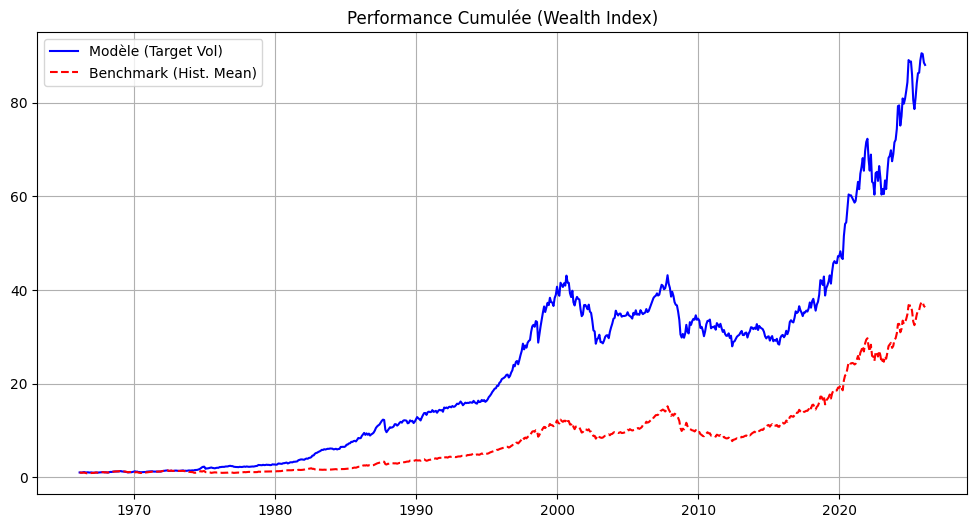

In [17]:
cum_ret_mod = (1 + portfolio_data['Port_Total']).cumprod()
cum_ret_ben = (1 + bench_data['Port_Total']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cum_ret_mod, label='Modèle (Target Vol)', color='blue')
plt.plot(cum_ret_ben, label='Benchmark (Hist. Mean)',
         color='red', linestyle='--')
plt.title('Performance Cumulée (Wealth Index)')
plt.legend()
plt.grid(True)
plt.show()

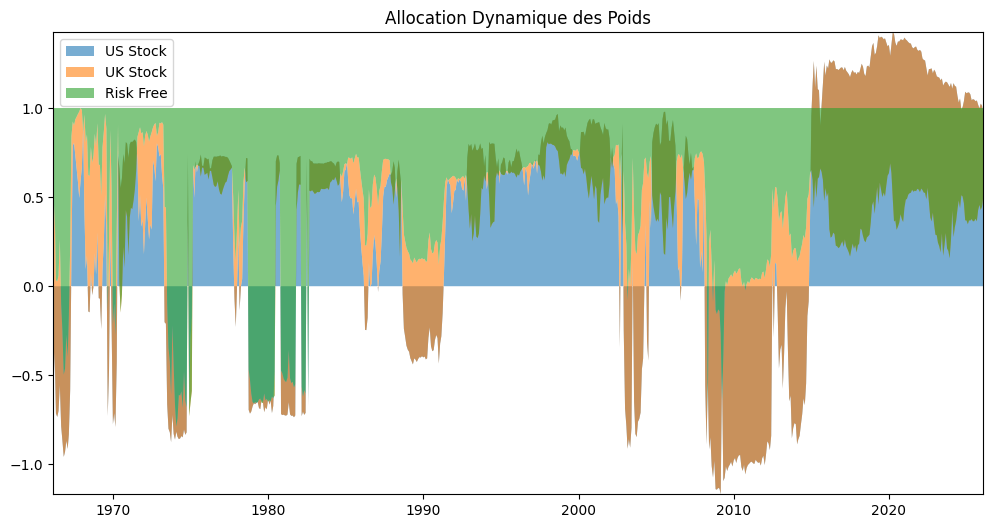

In [18]:
# B. Portfolio Weights
# Graphique en aires empilées (Stacked Area)
plt.figure(figsize=(12, 6))
plt.stackplot(portfolio_data.index,
              portfolio_data['Weight_US'],
              portfolio_data['Weight_UK'],
              portfolio_data['Weight_RF'],
              labels=['US Stock', 'UK Stock', 'Risk Free'],
              colors=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.6)
plt.title('Allocation Dynamique des Poids')
plt.legend(loc='upper left')
plt.margins(0, 0)
plt.show()

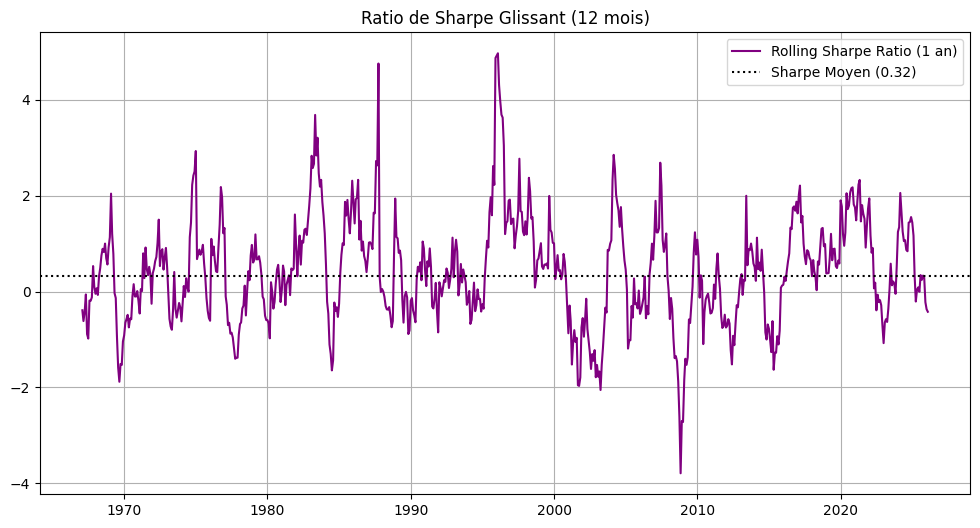

In [19]:
# C. One-Year Rolling Sharpe Ratio
# Calcul fenêtre glissante 12 mois
rolling_mean = portfolio_data['Port_Excess'].rolling(12).mean() * 12
rolling_std = portfolio_data['Port_Excess'].rolling(12).std() * np.sqrt(12)
rolling_sr = rolling_mean / rolling_std

plt.figure(figsize=(12, 6))
plt.plot(rolling_sr, label='Rolling Sharpe Ratio (1 an)', color='purple')
plt.axhline(sharpe_ratio, color='black', linestyle=':',
            label=f'Sharpe Moyen ({sharpe_ratio:.2f})')
plt.title('Ratio de Sharpe Glissant (12 mois)')
plt.legend()
plt.grid(True)
plt.show()